# UMAP을 이용한 차원축소 및 HDBSCAN을 통한 군집화
- colab에서 돌리는 버전

In [1]:
#UMAP이 없다면 해당 라이브러리 설치 필수
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 954.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=1779658a1c99fcbd98f9fa6393542fa3215e8e8d88926f85006c0e55e4947d2f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=bc1fa70f349bea51ac213639abf0aeed03f851a80af86e61ca7afb82a1381ed5
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
#HDBSCAN이 없다면 해당 라이브러리 설치 필수
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039185 sha256=3489e3fee7e6d6309893744a970a30e6003858f7e8eccec5d81f12dfa24da236
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import json
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import numpy as np
import pandas as pd
import gzip
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set(style='white', context='notebook', rc={'figure.figsize':(5,5)})
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams['font.family'] = 'Malgun Gothic'

# 1. 임베딩 값 구하기

In [82]:
# json file에서 query와 topic추출

with open('/content/drive/MyDrive/topic_extraction/preprocessed.json') as f:
    json_data = json.load(f)

topic_list = []
for i in range(len(json_data)):
  topic_list.append(json_data[i]['topic'])

model = AutoModel.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'
tokenizer = AutoTokenizer.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'

# 임베딩값 얻기
def get_embeddings(text):
    inputs_output = tokenizer(text, max_length=32, padding='max_length', truncation=True, return_tensors='pt')
    embeddings_output, _ = model(**inputs_output, return_dict = False)
    average_embedding = torch.mean(embeddings_output, dim=1)
    result_embedding = average_embedding.tolist()[0]
    return result_embedding

In [87]:
topic_list = topic_list[:100]

In [88]:
embed_list = []
print('딥러닝 모델을 활용한 임베딩: ')
for t in tqdm(topic_list):
  embed_list.append(get_embeddings(t))

# topic과 이에 대한 kosimCSE 임베딩값으로 구성된 데이터프레임 출력
embed_df = pd.DataFrame(embed_list, index=topic_list, columns=range(768))

딥러닝 모델을 활용한 임베딩: 


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


In [20]:
embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
네트워크 보안의 중요성,0.116927,0.681634,-0.152466,-1.229325,-0.207835,-0.178415,-0.246345,-0.155677,0.533144,-1.019330,...,-0.320203,-0.097272,0.379037,0.216836,-0.191186,-0.645656,0.115158,0.553350,-0.129277,0.094014
구의 표면적 계산,-0.261554,-0.544069,0.029593,-0.322763,0.089181,-0.231930,0.614833,-0.381301,-0.172061,0.315408,...,0.316477,0.682708,0.796344,-0.225746,-0.396274,-0.571863,0.148959,0.091684,0.007381,-0.248934
Javascript 함수 코딩,-0.672415,-0.110136,0.128165,-0.043420,-0.596236,-0.454626,-0.107101,0.225913,-0.572920,-0.086770,...,-0.089988,-0.008676,0.172871,-0.389015,-0.641723,-0.523898,-0.311032,0.635408,0.123137,-0.615767
시간 관리 방법,-0.550109,0.209159,-0.302087,-0.359368,-0.127091,0.039304,0.669858,-0.284322,-0.321336,0.210889,...,0.099965,0.925298,0.084155,-0.058148,-0.559757,0.111023,-0.196492,-0.590140,-0.683530,-0.094504
마카크의 자신감 있는 대화,-0.436227,0.450526,-0.619839,-0.765269,0.678008,-0.215378,0.325732,-0.133127,-0.581570,0.876298,...,0.825502,0.574572,-0.372033,-0.687054,-0.296533,-1.069723,-0.422591,-0.160051,0.456750,-0.338704


# 2. UMAP을 이용한 차원축소

## UMAP
toplogical 데이터 분석으로 manifold learning기술을 기반으로 한 차원 축소 알고리즘
t-SNE, PCA 보다 카테고리 간 분리가 명확하게 되어있으며 빠른 시간에 차원을 축소할 수 있음. 두 가지 주요한 파라미터를 사용:

credits: [https://m.blog.naver.com/myohyun/222421460444](https://m.blog.naver.com/myohyun/222421460444)

**1) n_neighbors:**<br>
초기 고차원 그래프 생성 시에 사용되는 nearest neighbor의 숫자로 가장 중요한 파라미터임
n_neighbors의 수가 작으면 : local stracture에 집중
n_neighbors의 수가 크면 : global stracture에 집중

**2) min_dist:**<br>
저차원 공간에서 포인트간의 최소 거리
umap이 얼마나 촘촘히 데이터를 묶을건지를 조절
min_dist값이 작으면: 포인트들이 촘촘하게 무리지어있게 됨
min_dist값이 크면: 포인트들이 상대적으로 느슨하게 퍼져있게 됨
n_neighbors가 커질수록 고차원 그래프에서 이웃한 데이터포인트간의 연결을 늘려 데이터의 전체적인 군집을 훨씬 더 정확하게 반영할 수 있음
min_dist값이 커지면 클러스터링을 약화시키고 global structure를 덜 강조함

**3)n_components:**<br>
줄여서 결과값으로 나오는 차원. 꼭 2차원이 아니어도 됨

In [67]:
### default setting:
#n_neighbors: float (optional, default 15)
#min_dist: float (optional, default 0.1)
#n_components: int (optional, default 2)
def umap_reducer(neighbors, min_distance, reduce_dim, data):
  print('UMAP을 통한 차원축소를 시작합니다...')
  reducer = umap.UMAP(low_memory = False, n_neighbors=neighbors, min_dist = min_distance, n_components = reduce_dim)
  embedding = reducer.fit_transform(data)
  # 데이터프레임 형태로 변환
  embedding_df = pd.DataFrame(embedding, index = topic_list)
  embedding_df.to_csv('../umap_reduce_result.csv', encoding = 'utf-8-sig')
  # 시각화
  plt.scatter(embedding.T[0], embedding.T[1], color='b')
  plt.legend(loc = 2, bbox_to_anchor = (1,1))
  plt.savefig('../umap_result.png')
  plt.show()
  return embedding_df

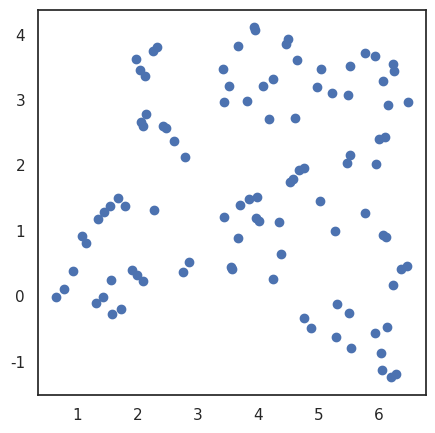

In [66]:
umap_df = umap_reducer(neighbors = 5, min_distance = 0.1, reduce_dim = 2, data = embed_df)

In [37]:
print(f'원본데이터 수: {embed_df.shape}')
print(f'차원축소한 데이터 수: {umap_df.shape}')

원본데이터 수: (100, 768)
차원축소한 데이터 수: (100, 2)


# 3. hdbscan을 통한 클러스터링 수행
dbscan + 계층적 클러스터링을 합한 개념
주요 하이퍼파라미터

credit: [https://hdbscan.readthedocs.io/en/latest/parameter_selection.html](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

**1)min_cluster_size**:<br>
하나의 군집에 최소로 들어갈 data 수

**2)min_samples**:<br>
The larger the value of `min_samples`you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

**3)cluster_selection_epsilon**:<br>
ensures that clusters below the given threshold are not split up any further. The choice of `cluster_selection_epsilon`depends on the given distances between your data points. For example, set the value to 0.5 if you don’t want to separate clusters that are less than 0.5 units apart.

### HDBSCAN의 default value
default values:<br>
HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
    
#### <b>여러실험 결과 최적의 파라미터값을 찾아내어 군집화 수행</b> ####

In [74]:
def hdbscan_cluster(min_size, min_sample, cluster_distance, data):
  print('hdbscan을 활용한 군집화를 시작합니다...')
  hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_size, min_samples = min_sample, cluster_selection_epsilon = cluster_distance, approx_min_span_tree=True)
  hdbscan_model.fit(data)
  hdbscan_labels = list(hdbscan_model.labels_)
  print(f'총 군집의 개수: {hdbscan_model.labels_.max()}')
  data['hdbscan_label'] = hdbscan_model.labels_
  data['hdbscan_label'] = data['hdbscan_label'].astype(str)
  data.rename(columns = {0: 'x', 1:'y'}, inplace = True)
  data.to_csv('./hdbscan_result.csv', encoding = 'utf-8-sig')
  sns.set(rc={'figure.figsize':(5,5)})
  ax = sns.scatterplot(x = 'x', y = 'y', hue = 'hdbscan_label', data = data, legend = False)
  plt.savefig('./hdbscan_scatter.png')
  plt.show()
  return data

총 군집의 개수: 13


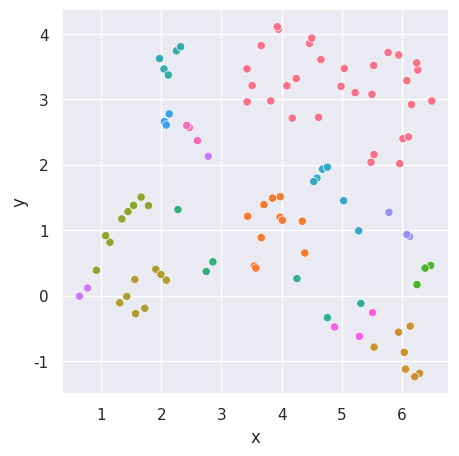

In [76]:
fin_df = hdbscan_cluster(min_size = 2, min_sample = None, cluster_distance = 0.1, data = umap_df)

**평가지표: Silhouette Score**

다른 클러스터(**seperation**)에 비해 자신의 클러스터(**cohesion**)와 얼마나 유사한 지 측정합니다. 실루엣 범위는 -1에서 +1까지이며, **값이 높으면 객체가 자체 클러스터와 잘 일치하고 인접 클러스터와 잘 일치하지 않음을 나타냅니다**. **대부분의 개체에 높은 값이 있으면 클러스터링 구성이 적합합니다. 0.25이상이면 됨**

In [77]:
# 모든 개별 데이터에 실루엣 계수값 구해 군집별 평균 실루엣계수 구하기
# 실루엣 계수값 바탕으로 어느 군집 제거할 것인지 판단

def cal_sihouette_score(data):
  X=data.iloc[:,:-1]
  labels=data.iloc[:,-1]
  score_samples=silhouette_samples(X, labels)
  data['silhouette_coeff']=score_samples
  num_cluster = data.groupby('hdbscan_label')['silhouette_coeff'].count()

  fin = data.groupby('hdbscan_label')['silhouette_coeff'].agg('mean')
  return fin

In [78]:
shil = cal_sihouette_score(data = fin_df)

In [92]:
shil.to_frame()

,silhouette_coeff
hdbscan_label,
-1,-0.509206
0,-0.245812
1,0.105836
10,0.720601
11,0.568075
12,0.406985
13,0.271799
2,0.663454
3,0.448376


In [47]:
import pandas as pd
dd = pd.read_csv('/home/minalang/umap_hdbscan_clustering/hdbscan_result.csv', index_col=0)

cond2 = fin_df['hdbscan_label'] == 99
cond3 = fin_df['hdbscan_label'] == 103
cond4 = fin_df['hdbscan_label'] == 104
cond5 = fin_df['hdbscan_label'] == 108

#print(f'101번 군집 토픽 내용: {dd[cond1].index}')
#print('-'*50)
print(f'99번 군집 토픽 내용: {fin_df[cond2].index}')
print('-'*50)
print(f'103번 군집 토픽 내용: {fin_df[cond3].index}')
print('-'*50)
print(f'104번 군집 토픽 내용: {fin_df[cond4].index}')
print('-'*50)
print(f'108번 군집 토픽 내용: {fin_df[cond5].index}')


99번 군집 토픽 내용: Index(['다양한 베리류 스무디', '바나나 스무디 만들기', '그린 스무디 레시피 가져오기', '베리 스무디 재료 목록 작성',
       '스무디 레시피 준비', '스무디 재료 생각하기', '딸기 스무디 제작', '스무디 레시피 제작', '스무디 재료 선택',
       '스무디 만들기 과정', '스무디 재료 선택', '스무디 재료 제안과 이점 설명', '스무디 레시피 개발',
       '스무디 레시피 재료 추천', '건강한 아침 스무디 레시피', '스무디 만드는 방법', '스무디 만들기', '스무디 재료 제안',
       '딸기 스무디 제조법', '스무디 재료 선택'],
      dtype='object')
--------------------------------------------------
103번 군집 토픽 내용: Index(['요가의 건강상 이점', '요가 팔다리 수', '요가의 이점', '어린이 요가의 이점', '요가의 이점', '요가 초보자 자세',
       '요가 인플루언서와 소셜 미디어', '요가 프로그램 디자인', '요가 블록 선택', '요가의 신체 건강 이점',
       '효과적인 허리 목 요가 자세', '발의 정렬과 바닥에 밀착하는 자세', '요가 수업 선택', '요가 자세 취하는 방법',
       ''요가' 번역', '요가 스튜디오 고객 유치 아이디어 추가', '요가의 정신 건강 이점', '요가의 건강상 이점',
       '요가 장비 나열', '명상의 요가 챕터'],
      dtype='object')
--------------------------------------------------
104번 군집 토픽 내용: Index(['단편 스토리 작성', '짧은 스토리 생성', '짧은 스토리 작성', '단편 스토리 작성', '짧은 스토리 작성',
       '시즌 3 에피소드 정보 알릭 사하로프', '짧은 스토리 생성', '짧은 서스펜스 스토리의 구조',
       '픽